In [61]:
import pymongo
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from dateutil import parser
from collections import Counter

from sksurv.nonparametric import kaplan_meier_estimator

from scripts import MONGO_URL
from scripts.analysis import data, plot

W, H = 5.5, 2.5
plot.init_matplotlib()

In [ ]:
repos = data.get_fake_star_repos()
stars = data.get_fake_stars_by_month()
repos_with_campaign = data.get_repos_with_campaign()
repos = repos[repos.repo_name.isin(repos_with_campaign)]

In [ ]:
repos["deleted"] = repos.repo_id.isna()
repos["n_stars_fake"] = repos.n_stars_low_activity + repos.n_stars_clustered
repo_to_len_campaign = Counter(stars[stars.anomaly].repo)
repos["length_campaign"] = repos.repo_name.map(lambda x: repo_to_len_campaign[x])

# Survial time
repo_to_active, missing = dict(), 0
with pymongo.MongoClient(MONGO_URL) as client:
    for repo in repos_with_campaign:
        events = list(
            client.fake_stars.fake_repo_events.find({"repo": repo}).sort(
                "created_at", pymongo.ASCENDING
            )
        )
        if len(events) == 0:
            repo_to_active[repo] = np.nan
        else:
            repo_to_active[repo] = (
                parser.parse(events[-1]["created_at"])
                - parser.parse(events[0]["created_at"])
            ).days + 1
repos["active_days"] = repos.repo_name.map(lambda x: repo_to_active[x])

  0%|          | 0/15835 [00:00<?, ?it/s]

100%|██████████| 15835/15835 [00:38<00:00, 416.56it/s]

0


In [33]:
repos[["n_stars_latest", "n_stars_fake", "length_campaign", "active_days"]].describe()

,n_stars_latest,n_stars_fake,length_campaign,active_days
count,15835.000000,15835.000000,15835.000000,10078.000000
mean,30.594127,194.167982,1.015535,54.151717
std,419.990042,217.547745,0.157379,206.171453
min,0.000000,50.000000,1.000000,1.000000
25%,0.000000,83.000000,1.000000,1.000000
50%,0.000000,128.000000,1.000000,1.000000
75%,0.000000,231.000000,1.000000,5.000000
max,27105.000000,11329.000000,6.000000,1920.000000


<Axes: xlabel='variable', ylabel='value'>

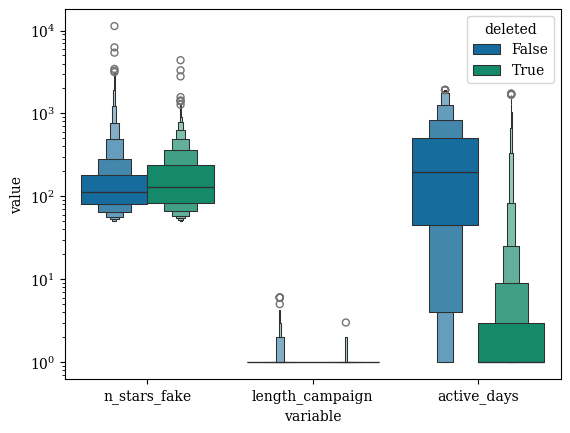

In [66]:
sns.boxenplot(
    data=repos.melt(
        id_vars="deleted",
        value_vars=["n_stars_fake", "length_campaign", "active_days"],
        value_name="value",
    ),
    x="variable",
    y="value",
    hue="deleted",
    log_scale=True,
)

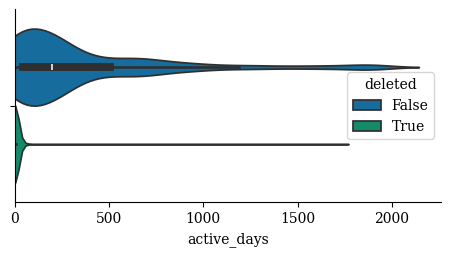

In [67]:
fig, ax = plt.subplots(1, 1, figsize=(W, H))
sns.violinplot(data=repos, x="active_days", hue="deleted", ax=ax)
ax.set_xlim(0)
plot.remove_spines(ax)

Text(0.5, 0, 'time $t$')

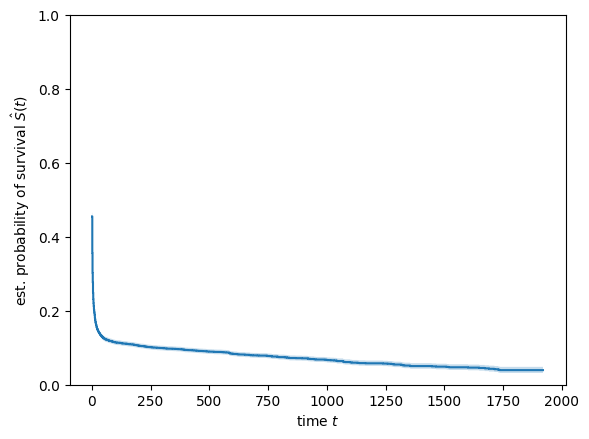

In [57]:
time, survival_prob, conf_int = kaplan_meier_estimator(
    repos[repos.active_days.notna()]["deleted"],
    repos[repos.active_days.notna()]["active_days"],
    conf_type="log-log",
)
plt.step(time, survival_prob, where="post")
plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
plt.ylim(0, 1)
plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")